<a href="https://colab.research.google.com/github/mersalas/ecosa/blob/main/ecoli_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install packages
#!pip install deepchem
#!pip install shap

In [2]:
# Import necessary libraries
from rdkit import Chem
import deepchem as dc
import joblib
import shap # feature importance
from shap import Explanation
from shap.plots import waterfall
shap.initjs()
from rdkit.Chem import Draw, rdMolDescriptors

2025-05-27 05:20:02.094344: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 05:20:02.119183: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-27 05:20:02.463896: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Skipped loading some Jax models, missing a dependency. No module named 'jax'


**Featurization**

In [3]:
# Load own peptides
own_data = 'https://raw.githubusercontent.com/mersalas/ISCAPE/main/dataset/Eco_own.csv'
df = pd.read_csv(own_data)
df.head()

<IPython.core.display.Javascript object>

,id,n_ter,seq,c_ter,smiles,uaa_pos,uaa_type,MIC_ugml,Ecoli
0,1,C14,GLLKRIKTLL,AMD,CCCCCCCCCCCCCC(=O)NCC(=O)N[C@@H](CC(C)C)C(=O)N...,NaN,NaN,1.6,1
1,2,C14,HH,AMD,NC(=O)[C@H](Cc1cnc[NH]1)NC(=O)[C@@H](NC(=O)CCC...,NaN,NaN,128.0,0
2,3,C14,RH,AMD,[NH2+]=C(N)NCCC[C@H](NC(=O)CCCCCCCCCCCCC)C(=O)...,NaN,NaN,4.0,1
3,4,C14,KH,AMD,CCCCCCCCCCCCCC(=O)N[C@@H](CCCC[NH3+])C(=O)N[C@...,NaN,NaN,8.0,1
4,5,C14,OH,AMD,CCCCCCCCCCCCCC(=O)N[C@@H](CCC[NH3+])C(=O)N[C@@...,1,Orn,2.0,1


In [4]:
# Function to calculate the total charge and fraction of C-C pairs
def calculate_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # calculate the fraction of C-C pairs
    num_bonds = mol.GetNumBonds()
    num_cc_pairs = sum(1 for bond in mol.GetBonds() if bond.GetBeginAtom().GetSymbol() == 'C' and bond.GetEndAtom().GetSymbol() == 'C')
    frac_CC = num_cc_pairs / num_bonds if num_bonds > 0 else 0
    
    return frac_CC

In [5]:
# Apply the function to each SMILES string in the DataFrame
df['frac_CC'] = df['smiles'].apply(calculate_properties)

# Scale fra_CC pairs column
scaler_qc = joblib.load('model/scaler_qc.pkl')
df[['frac_CC']] = scaler_qc.transform(df[['frac_CC']])

In [6]:
# Featurize smiles
tasks = ['Ecoli']
featurizer = dc.feat.CircularFingerprint(radius=7, size=512, chiral=True, bonds=True,
                                        features=True, is_counts_based=True)

loader = dc.data.CSVLoader(tasks=tasks, feature_field='smiles', featurizer=featurizer)
dataset = loader.create_dataset(own_data)

**Scaling & Normalization**

In [7]:
# Scale ECFPs columns
scaler_ecfp = joblib.load('model/scaler_ecfp.pkl')
X_scale = scaler_ecfp.transform(dataset.X)

# Convert dataset.X to DataFrame
ecfp = pd.DataFrame(X_scale)
col = ['ECFP' + str(x) for x in range(0,512)]
ecfp.columns = col

<IPython.core.display.Javascript object>

In [8]:
# Concatenate Q & frac_CC columns with the ECFPs
X = pd.concat([df[['frac_CC']], ecfp], axis=1)
X

<IPython.core.display.Javascript object>

,frac_CC,ECFP0,ECFP1,ECFP2,ECFP3,ECFP4,ECFP5,ECFP6,ECFP7,ECFP8,...,ECFP502,ECFP503,ECFP504,ECFP505,ECFP506,ECFP507,ECFP508,ECFP509,ECFP510,ECFP511
0,0.751899,-0.025,-0.266667,-0.357143,-0.5,-0.8125,0.5,0.0,0.0,0.0,...,0.0,0.5,-0.333333,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.424166,-1.225,-1.066667,-1.214286,-0.5,-0.5000,0.5,2.0,0.0,0.0,...,0.0,0.5,-1.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.424166,-1.150,-1.066667,-1.142857,-1.0,-0.6875,0.0,1.0,0.0,0.0,...,0.0,0.0,-1.222222,-0.5,1.0,0.0,0.0,0.0,0.0,0.0
3,1.336832,-1.150,-1.066667,-1.142857,-1.0,-0.6875,0.0,1.0,0.0,0.0,...,0.0,0.0,-1.222222,-0.5,1.0,0.0,0.0,0.0,0.0,0.0
4,1.173395,-1.175,-0.977778,-1.142857,-1.0,-0.6875,0.0,1.0,0.0,0.0,...,1.0,0.0,-1.222222,-0.5,0.0,0.0,0.0,0.0,1.0,0.0
5,1.000052,-1.200,-1.066667,-1.142857,-1.0,-0.6250,0.0,1.0,0.0,0.0,...,0.0,0.0,-1.222222,-0.5,0.0,0.0,0.0,0.0,0.0,0.0
6,0.815876,-1.225,-1.066667,-1.142857,-1.0,-0.6875,0.0,1.0,0.0,0.0,...,0.0,0.0,-1.222222,-0.5,0.0,0.0,0.0,0.0,0.0,0.0
7,0.244457,-1.025,-0.977778,-1.000000,-1.0,-0.6875,0.0,1.0,0.0,0.0,...,1.0,0.0,-1.000000,-0.5,0.0,0.0,0.0,0.0,0.0,0.0
8,0.719403,-0.600,-0.888889,-0.857143,-1.0,-0.6875,0.5,2.0,0.0,0.0,...,0.0,0.0,-0.888889,-0.5,1.0,0.0,0.0,0.0,0.0,0.0
9,1.000052,-0.175,-0.355556,-0.500000,-1.0,-0.0625,1.0,3.0,0.0,0.0,...,0.0,0.5,-0.444444,-0.5,1.0,0.0,0.0,1.0,0.0,0.0


In [9]:
# Normalize the data
normalizer = joblib.load('model/normalizer.pkl')
X_norm = normalizer.transform(X)

In [10]:
# Convert X_norm into DataFrame
X_norm = pd.DataFrame(X_norm, columns=X.columns)
X_norm.head()

<IPython.core.display.Javascript object>

,frac_CC,ECFP0,ECFP1,ECFP2,ECFP3,ECFP4,ECFP5,ECFP6,ECFP7,ECFP8,...,ECFP502,ECFP503,ECFP504,ECFP505,ECFP506,ECFP507,ECFP508,ECFP509,ECFP510,ECFP511
0,0.554659,0.364198,0.302326,0.228070,0.071429,0.010870,0.10,0.00,0.0,0.0,...,0.000000,0.095238,0.272727,0.090909,0.166667,0.0,0.0,0.0,0.00,0.0
1,0.500388,0.067901,0.093023,0.017544,0.071429,0.065217,0.10,0.10,0.0,0.0,...,0.000000,0.095238,0.060606,0.090909,0.000000,0.0,0.0,0.0,0.00,0.0
2,0.500388,0.086420,0.093023,0.035088,0.000000,0.032609,0.05,0.05,0.0,0.0,...,0.000000,0.047619,0.030303,0.000000,0.166667,0.0,0.0,0.0,0.00,0.0
3,0.651522,0.086420,0.093023,0.035088,0.000000,0.032609,0.05,0.05,0.0,0.0,...,0.000000,0.047619,0.030303,0.000000,0.166667,0.0,0.0,0.0,0.00,0.0
4,0.624458,0.080247,0.116279,0.035088,0.000000,0.032609,0.05,0.05,0.0,0.0,...,0.166667,0.047619,0.030303,0.000000,0.000000,0.0,0.0,0.0,0.25,0.0


**Prediction**

In [11]:
# Load the model
svc = joblib.load('model/svc.pkl')

In [12]:
# Predict activity of own peptides
pred = svc.predict(X_norm)
pred

array([1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0])

**Interpretation**

In [13]:
# Initialize the SHAP explainer
explainer = shap.KernelExplainer(svc.predict, X_norm)
shap_values = explainer.shap_values(X_norm)

  0%|          | 0/11 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


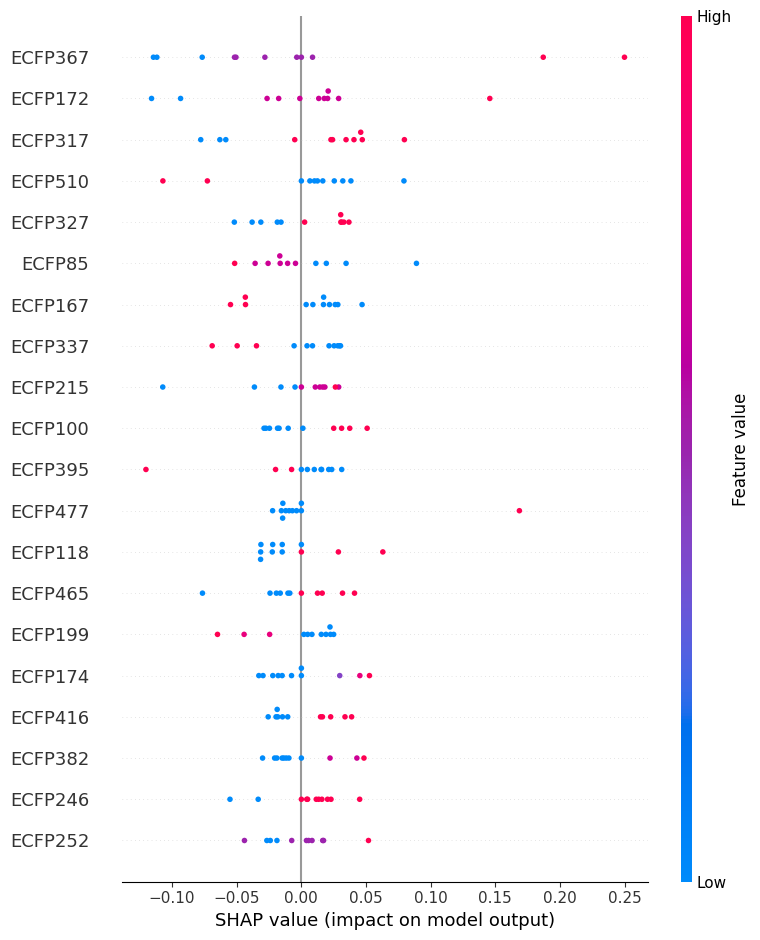

In [15]:
# Plot SHAP values
shap.summary_plot(shap_values, X_norm)

In [16]:
def highlight_ecfp_substructure(smiles, important_bits, radius, size):
    """
    Highlights substructures in a molecule corresponding to important ECFP bits.
    
    Parameters:
    - smiles: SMILES string of the molecule.
    - important_bits: List of bit indices identified as important by SHAP.
    - radius: Radius used for generating ECFP.
    - size: Size of the ECFP vector.
    
    Returns:
    - img: Image of the molecule with highlighted substructures.
    """
    # Convert SMILES to RDKit molecule object
    molecule = Chem.MolFromSmiles(smiles)

    # Initialize Morgan (ECFP) fingerprint with RDKit
    info = {}
    ecfp_vector = rdMolDescriptors.GetMorganFingerprintAsBitVect(
        molecule, radius, nBits=size, bitInfo=info, useChirality=True, useBondTypes=True, useFeatures=True
    )

    # Highlight atoms corresponding to important bits
    highlight_atoms = set()
    for bit in important_bits:
        if bit in info:
            for atom_idx, radius in info[bit]:
                # Add all atoms in the substructure centered around atom_idx within the radius
                env = Chem.FindAtomEnvironmentOfRadiusN(molecule, radius, atom_idx)
                for bond_idx in env:
                    bond = molecule.GetBondWithIdx(bond_idx)
                    highlight_atoms.add(bond.GetBeginAtomIdx())
                    highlight_atoms.add(bond.GetEndAtomIdx())
    
    # Draw molecule with highlighted atoms
    img = Draw.MolToImage(molecule, size=(300, 300), highlightAtoms=list(highlight_atoms))
    return img

**Myr-anoplin**

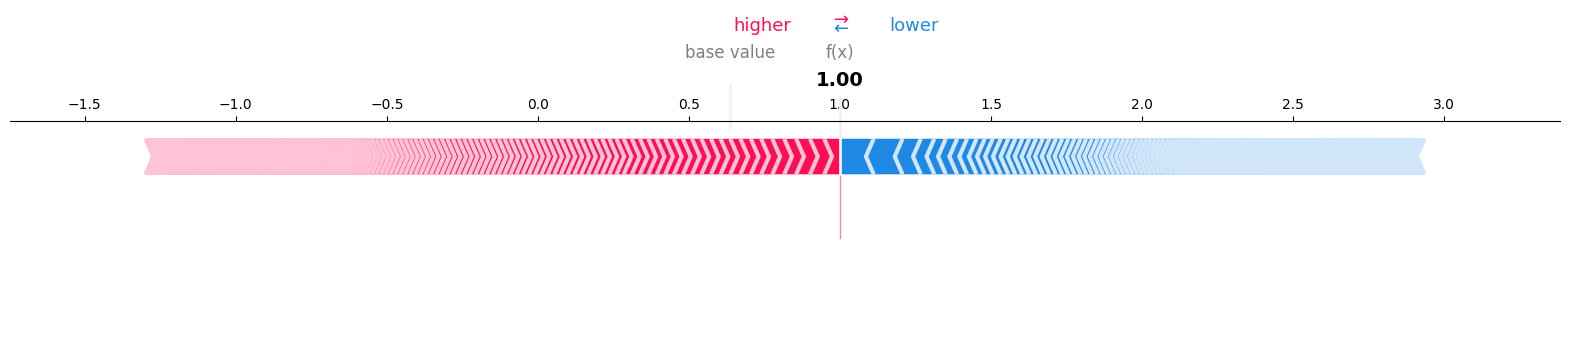

In [17]:
# Force plot
shap.force_plot(explainer.expected_value, shap_values[0],
               X_norm.iloc[0], matplotlib=True)

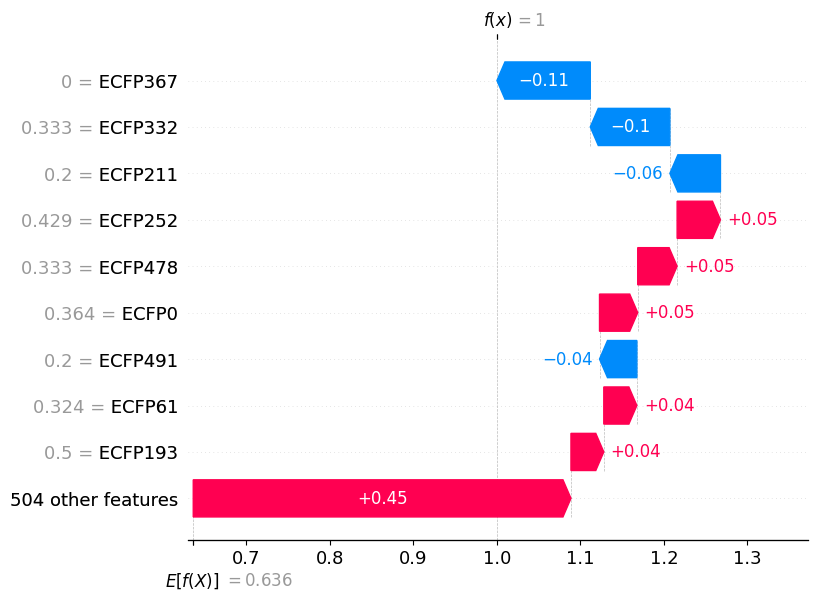

In [18]:
# Waterfall plot
explain = shap.Explanation(shap_values[0], 
                               explainer.expected_value,
                              X_norm.iloc[0])
shap.plots.waterfall(explain, max_display=10)

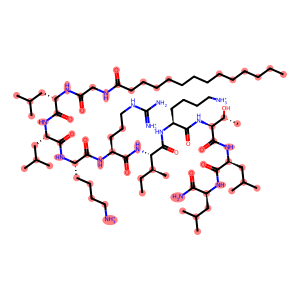

In [20]:
# Positive SHAP
smiles = dataset.ids
smiles = smiles[0] # SMILES string for a particular instance
important_bits = [252, 478, 61, 193] # important ECFP bits identified by SHAP
img = highlight_ecfp_substructure(smiles, important_bits, radius=7, size=512)
img

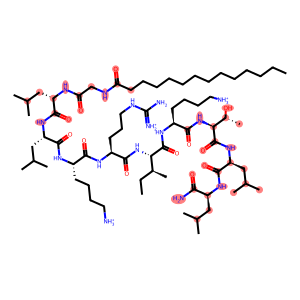

In [35]:
# Negative SHAP
smiles = dataset.ids
smiles_string = smiles[0] 
important_bits = [367, 332, 211, 491]
img = highlight_ecfp_substructure(smiles_string, important_bits, radius=5, size=1024)
img

**Myr-OHR-NH2**

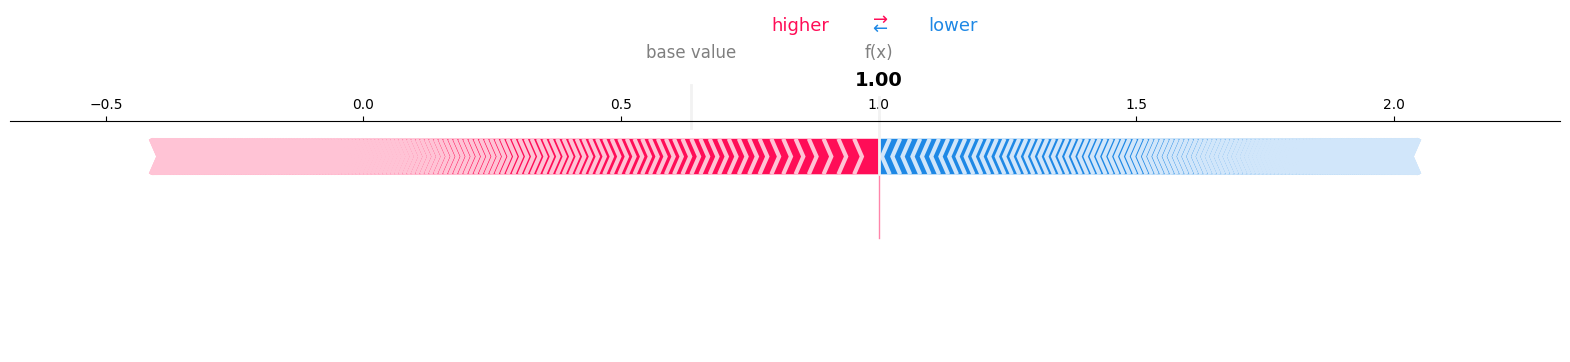

In [23]:
# Force plot
shap.force_plot(explainer.expected_value, shap_values[7],
               X_norm.iloc[7], matplotlib=True)

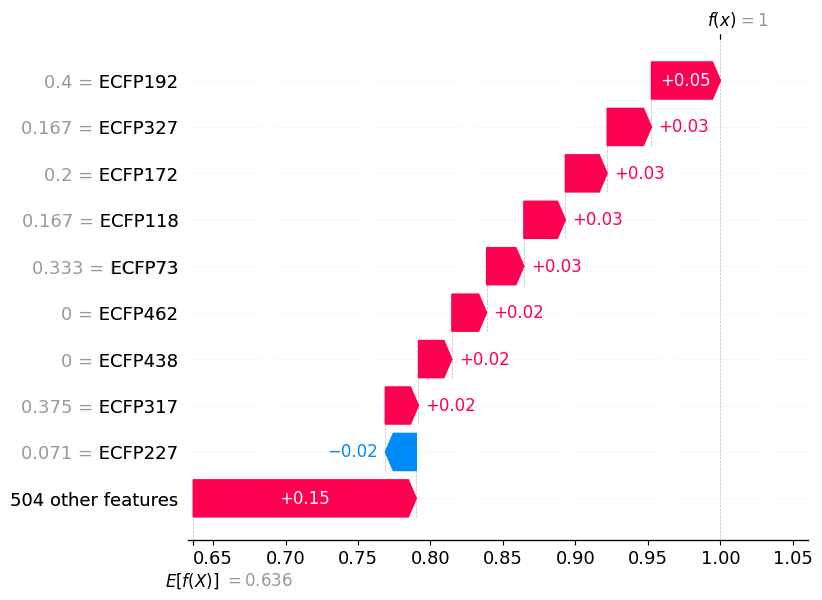

In [24]:
# Waterfall plot
explain = shap.Explanation(shap_values[7], 
                               explainer.expected_value,
                              X_norm.iloc[7])
shap.plots.waterfall(explain, max_display=10)

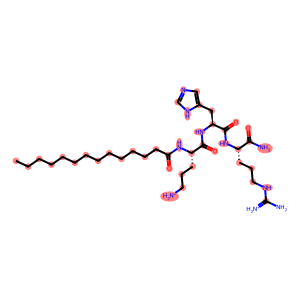

In [33]:
# Positive SHAP
smiles = dataset.ids
smiles = smiles[7] # SMILES string for a particular instance
important_bits = [192, 327, 172, 118, 73, 317]  # important ECFP bits identified by SHAP
img = highlight_ecfp_substructure(smiles, important_bits, radius=7, size=512)
img

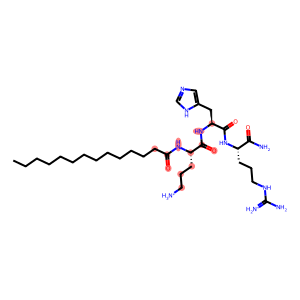

In [34]:
# Negative SHAP
smiles = dataset.ids
smiles_string = smiles[7] 
important_bits = [227]
img = highlight_ecfp_substructure(smiles_string, important_bits, radius=7, size=512)
img